# Bitcoin Volatility Surface using SVI Parameterisation

In [25]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import least_squares,curve_fit
from scipy.interpolate import pchip_interpolate

pd.set_option('display.max_columns', 100)

## Introduction

In this notebook, we aim to explore using the SVI method to create an arbitrage free BTC volatiltiy surface.

### What is a volatility surface?

If we use the Black-Scholes pricing formula to back out underlying volatility ($\sigma$) from option prices we would see that this implied volatility is function of two variables: time to maturiry (T) and the strike price (K). This gives us the implied volatility surface.

### What should it look like?

Two key characteristics:
- On the strike dependant axis, the surface has a smile profile which tends to flatten out as you get further away from maturity.
- On the time dependant axis, the surface has a linear profile.

## Raw SVI Paramaterisation

The Raw SVI model belongs to a group of parametric represntation models known as the Stochastic Volatility Inspired (SVI) family.

The formula below is the raw parameterization of the total implied variance, for a fixed time to maturity, where $x$ is moneyness and $\{a,b,\sigma,\rho,m\}$ are parameters we need to estimate using market data. 

$$ w_{imp}^{svi} = a + b\cdot\left({\rho}\cdot\left(x-m\right) + \sqrt{\left(x-m\right)^2+{\sigma}^2}\right) $$

Where the total implied variance can be defined a,

$$ w_{imp} = \sigma_{imp}^{2}T $$

In essense, the formula is essentially defining the smile profile at a certain time to maturity.

In [10]:
def raw_svi(x,a,b,sigma,rho,m):
    return a + b * (rho*(x - m) + ((x - m)**2 + sigma**2)**0.5)

### Market data

To create our volatility surface we first need to obtain some market data to estimate the SVI model parameters. We chose to use market data from the deribit exchange as they have the most liquidity. The data was collected on 22nd April 2022.

In order to prepare the data we must do the following:
- remove ITM options
- calculate log moneyness / log strike (i.e. $ x = ln(K/S)$)
- calculate time to expiry in years

Its worth noting that on deribit, the underlying of the option is the derbit future with the same expiry date. Furthermore, in cases where there isn't an equivalent future deribit use a synthetic future - which isn't actually tradable on their exchange.

In [2]:
evaluation_date = datetime.datetime(2022,4,20,19,30,0)

In [3]:
btc_options = pd.read_csv('data/data_BTC.csv')

In [4]:
def prepare_data(df, evaluation_date):
    df.loc[df['option_type']=='put','moneyness'] = np.log(df['strike']/df['underlying_price'])
    df.loc[df['option_type']=='call','moneyness'] = np.log(df['underlying_price']/df['strike'])
    df['expiration_date'] = pd.to_datetime(df['expiration_timestamp'], unit='ms', origin='unix')
    df['time_to_expiry_yrs'] = (df['expiration_date'] - evaluation_date).astype('timedelta64[h]') / 24 /365
    df['mid_iv'] = df['mark_iv'] / 100
    
    filtered = df[df['moneyness']>0].copy()
    filtered['log_moneyness'] = np.log(filtered['strike']/filtered['underlying_price'])
    
    result = filtered[
        ['option_type', 'greeks.vega', 'stats.volume','strike','log_moneyness', 'time_to_expiry_yrs', 'mid_iv']
    ].sort_values(by=['time_to_expiry_yrs', 'log_moneyness']).copy()
    
    return result

In [5]:
btc_market = prepare_data(btc_options, evaluation_date)

In [9]:
btc_market[['log_moneyness', 'time_to_expiry_yrs', 'mid_iv']].head()

,log_moneyness,time_to_expiry_yrs,mid_iv
59,-0.252438,0.00137,0.7583
294,-0.191608,0.00137,0.7583
263,-0.162676,0.00137,0.7583
292,-0.134450,0.00137,0.7583
371,-0.107003,0.00137,0.7571


### Initial Optimisation

In order to find the best parameters, we define a least-squares optimisation problem. This is then solved for each time to maturity slice given us our set of parameters for each slice.

$$ \min_{a,b,\sigma,\rho,m}\sum_{i=1}^{n}(w_{raw}(x,a,b,\sigma,\rho,m) - w_{market})^2 $$

In [11]:
def residual(params,T, market):
    w = [raw_svi(x,*params) for x in market.loc[market['time_to_expiry_yrs']==T, 'log_moneyness']]
    iv_actual = market.loc[market['time_to_expiry_yrs']==T, 'mid_iv']
    return iv_actual - (w/T)**0.5

In [12]:
results = []
for T in btc_market['time_to_expiry_yrs'].unique():
    
    initial_guess = [0,0,0,0,0] 
    result = least_squares(residual, initial_guess, max_nfev=1000, args=(T, btc_market), verbose=0)
    results.append(result)
    
    if result.success:
        print(f'Ran for T = {T:.4f}: SUCCESS')
    else:
        print(f'Ran for T = {T:.4f}: FAILED')
        
    print('----------------------')

Ran for T = 0.0014: SUCCESS
----------------------
Ran for T = 0.0041: SUCCESS
----------------------
Ran for T = 0.0233: SUCCESS
----------------------
Ran for T = 0.0425: SUCCESS
----------------------
Ran for T = 0.1000: SUCCESS
----------------------
Ran for T = 0.1767: SUCCESS
----------------------
Ran for T = 0.4452: SUCCESS
----------------------
Ran for T = 0.6945: SUCCESS
----------------------
Ran for T = 0.9438: SUCCESS
----------------------


The table below details our parameter set for each time to expiry slice of our implied volatility surface.

In [13]:
def create_param_matrix(market, results):
    param_matrix = pd.DataFrame(
        columns=market['time_to_expiry_yrs'].unique(), 
        index=['a','b','\u03C3', '\u03c1', 'm'],
    )
    
    for i, result in enumerate(results):
        param_matrix.iloc[:,i] = result.x
    
    return param_matrix

In [14]:
param_matrix = create_param_matrix(btc_market, results)
param_matrix

,0.001370,0.004110,0.023288,0.042466,0.100000,0.176712,0.445205,0.694521,0.943836
a,0.000457,1.179467e-03,0.005081,-0.006441,0.006889,-0.016696,-0.007773,-2.087730,-4.221682
b,0.002279,4.356221e-03,0.024854,0.067985,0.098872,0.159236,0.230159,0.817591,1.321736
σ,0.000003,-7.494177e-07,0.038686,0.282037,-0.244067,-0.453637,0.753405,-3.156541,-4.203748
ρ,0.205962,-5.006764e-01,-0.228966,-0.199753,-0.259551,-0.084862,-0.211268,-0.406241,-0.558252
m,0.015230,1.952358e-02,0.032366,0.008132,0.013245,0.111213,0.036428,-1.100699,-2.515605


We can then plot each of these smiles against the actual market data to examine the fit. As you can see from the figure below the smiles, at different time to maturities, fit very well with our market data other than when T = 0.0014 years (approx half a day). It also displays some of the key characteristic of the expected smile profile we discussed above.

In [15]:
def generate_surface(market, param_matrix):
    m = np.linspace(-2.25, 2.25)
    iv_ssvi = {}
    for T in btc_market['time_to_expiry_yrs'].unique():
        w_ssvi = [raw_svi(x, *param_matrix[T].tolist()) for x in m]
        iv_ssvi[T] = (w_ssvi/T)**0.5
        
    return m, iv_ssvi

m, iv_ssvi = generate_surface(btc_market, param_matrix)

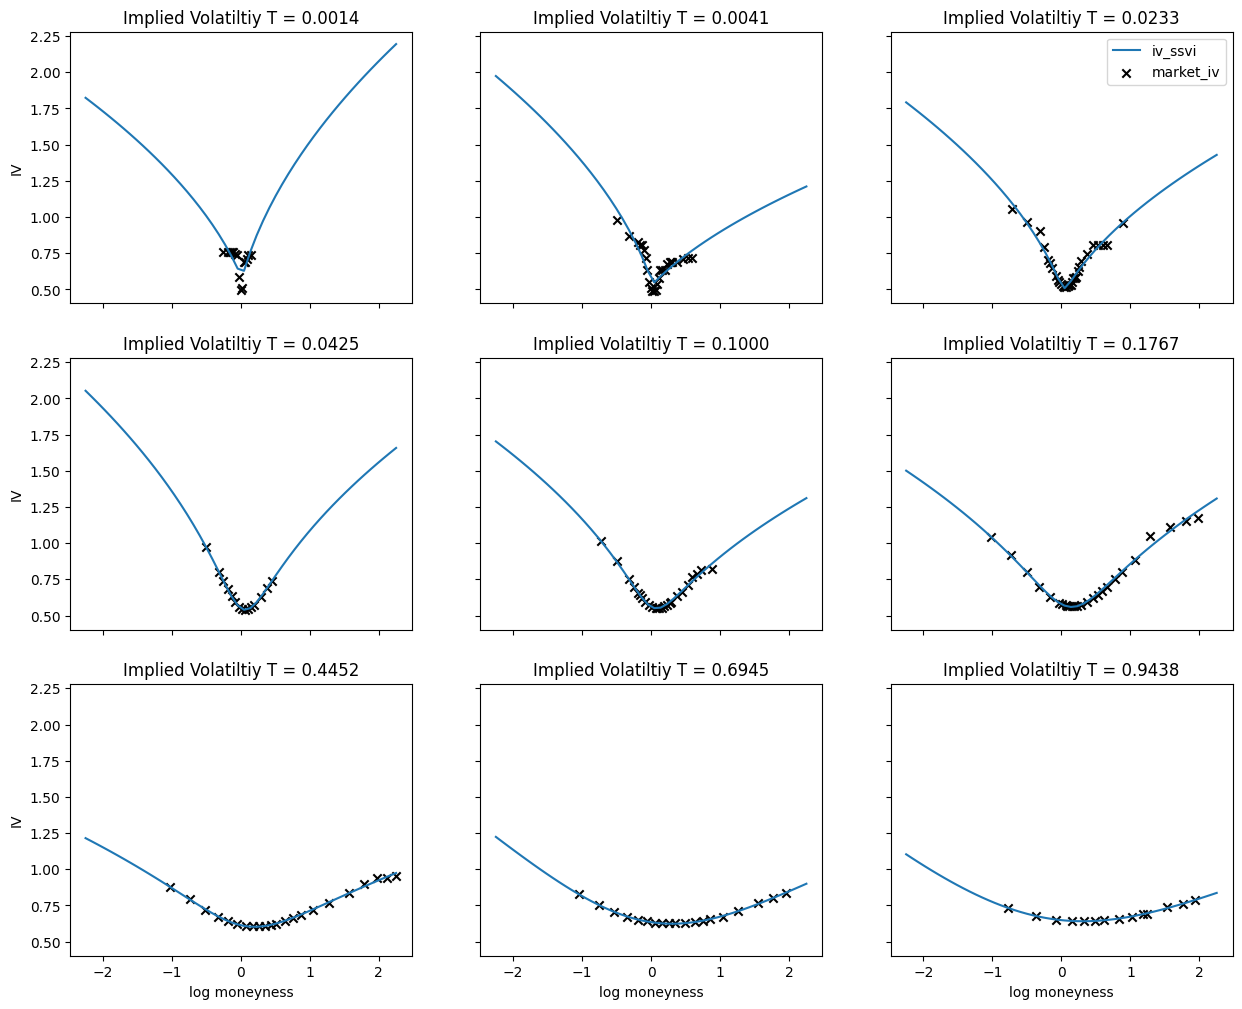

In [16]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,12))

for i,T in enumerate(btc_market['time_to_expiry_yrs'].unique()):
    row = int(i/3)
    col = i - 3*row
    
    ax[row,col].plot(m, iv_ssvi[T], label='iv_ssvi')
    
    real_m = btc_market.loc[btc_market['time_to_expiry_yrs']==T, 'log_moneyness']
    real_iv = btc_market.loc[btc_market['time_to_expiry_yrs']==T, 'mid_iv']
    ax[row,col].scatter(real_m, real_iv, marker='x',color='black', label='market_iv')
    
    ax[row,col].set_title(f"Implied Volatiltiy T = {T:.4f}")
    
    if col == 0:
        ax[row,col].set_ylabel("IV")
        
    if row == 2:
        ax[row,col].set_xlabel("log moneyness")
        
    if row == 0 and col ==2:
        ax[row,col].legend()
    

We will use monotonic spline interpolation to interpolate between slices. So we are able to calculate the IV for options with a time to maturity between those we have market data for. 

In [82]:
def interpolate_surface(x, y, z, no_points):
    
    intr_y = np.linspace(min(y), max(y), no_points)
    intr_z = []
    for idx, point in enumerate(x):
        temp = pchip_interpolate(y, z[:,idx], intr_y)
        intr_z.append(temp)
        
    return intr_y, np.array(intr_z).T

The figure below is a plot of our volatility surface. It is important to note that as each fit is done independantly there is an opportunity to introduce static arbitrage.

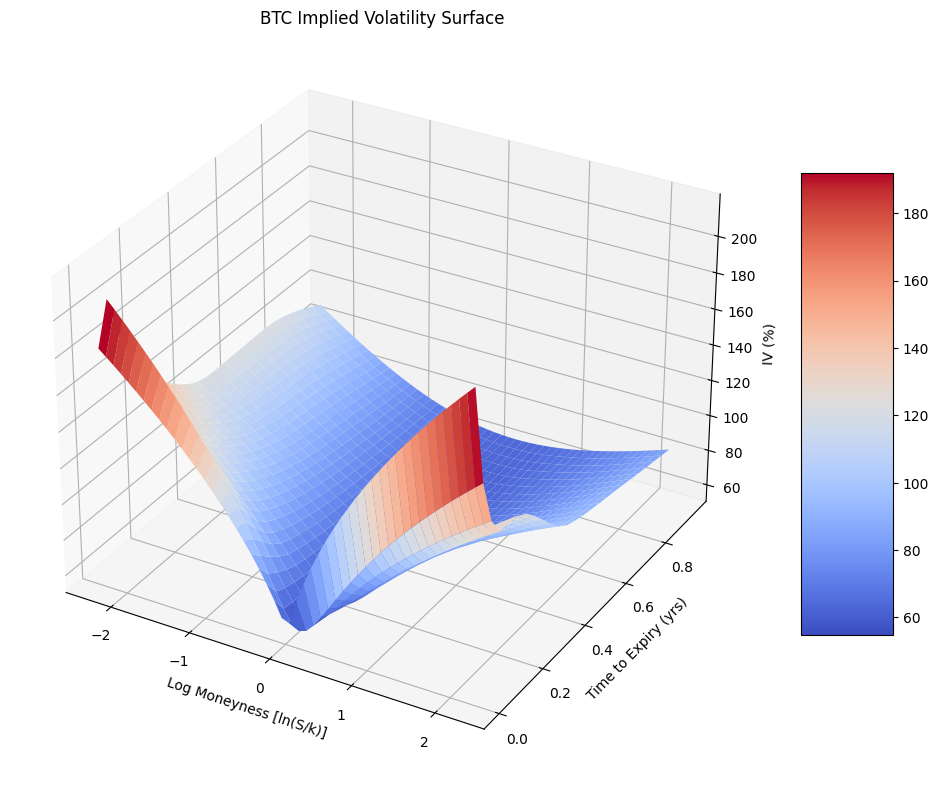

In [86]:
def plot_surface(market, m, iv_ssvi, no_points):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    x = m
    y = market['time_to_expiry_yrs'].unique() 
    
    z = []
    for T in market['time_to_expiry_yrs'].unique():
        z.append(iv_ssvi[T])
    z = np.array(z)
    
    intr_y, intr_z = interpolate_surface(x, y, z, no_points)
    
    X, Y = np.meshgrid(x,intr_y)
    Z = intr_z * 100
    

    surf = ax.plot_surface(X, Y, Z, cmap="coolwarm")
    ax.set_xlabel('Log Moneyness [ln(S/k)]')
    ax.set_ylabel('Time to Expiry (yrs)')
    ax.set_zlabel('IV (%)')
    ax.set_title('BTC Implied Volatility Surface')
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
plot_surface(btc_market, m, iv_ssvi, 25)

## Handling Arbitrage

### Evaluating Static Arbitrage

Static arbitrage opportunities occur as a result of options being miss-priced relative to another option. This is could either be as a result of miss-pricing between options of different maturities or different strikes.

In the case of different maturities this leads to a calender arbitrage. An implied volatility surface is free of this arbitrage if the below condition is met,

$$ w_{imp}(x, \tau_1) < w_{imp}(x, \tau_2) \text{ for all maturities } \tau_1 < \tau < \tau_2 $$

The butterfly arbitrage is as a result of miss-pricing between different strikes. An implied volatility surface is free of this arbitrage if the Durrleman's Condition is met. This is defined as,

$$ 0 \leq g(x) = (1 - \frac{x\Sigma_x}{\Sigma})^2 - \frac{1}{4}\Sigma^2\Sigma_x^2 + \Sigma\Sigma_{xx} $$

In the above equation $\Sigma$ is the total implied volatility, $\Sigma_{x}$ is the first partial derivative with respect to $x$, and $\Sigma_{x}$ is the second partial derivative with respect to x. The below equations evaluate each of these derivatives with regards to the raw svi parametrisation.

$$\Sigma = \sigma_{imp}(x,\tau)\sqrt{\tau} = \sqrt{a + b\cdot\left({\rho}\cdot\left(x-m\right) + \sqrt{\left(x-m\right)^2+{\sigma}^2}\right)} $$

$$\Sigma_x = \dfrac{b\cdot\left(\frac{x-m}{\sqrt{\left(x-m\right)^2+{\sigma}^2}}+{\rho}\right)}{2\sqrt{b\cdot\left(\sqrt{\left(x-m\right)^2+{\sigma}^2}+{\rho}\cdot\left(x-m\right)\right)+a}}$$

$$\Sigma_{xx} = \dfrac{b{}\cdot\left(\frac{1}{\sqrt{\left(x-m\right)^2+{\sigma}^2}}-\frac{\left(x-m\right)^2}{\left(\left(x-m\right)^2+{\sigma}^2\right)^\frac{3}{2}}\right)}{2\sqrt{b\cdot\left(\sqrt{\left(x-m\right)^2+{\sigma}^2}+{\rho}\cdot\left(x-m\right)\right)+a}}-\dfrac{b^2{}\cdot\left(\frac{x-m}{\sqrt{\left(x-m\right)^2+{\sigma}^2}}+{\rho}\right)^2}{4\left(b\cdot\left(\sqrt{\left(x-m\right)^2+{\sigma}^2}+{\rho}\cdot\left(x-m\right)\right)+a\right)^\frac{3}{2}}$$



In [36]:
def Sigma(x,a,b,sigma,rho,m):
    return (raw_svi(x,a,b,sigma,rho,m)**0.5)

def Sigma_x(x,a,b,sigma,rho,m):
    
    denominator = 2*raw_svi(x,a,b,sigma,rho,m)**0.5
    numerator = b*(((x-m)/(((x-m)**2+sigma**2)**0.5)) + rho)
    
    return numerator/denominator

def Sigma_xx(x,a,b,sigma,rho,m):
    
    numerator_a = b * ( ((x-m)**2 + sigma**2)**-0.5 - ((x-m)**2)/((x-m)**2 + sigma**2)**1.5 )
    denominator_a = 2*raw_svi(x,a,b,sigma,rho,m)**0.5
    
    numerator_b =  b**2 *((x-m)/((x-m)**2 +sigma**2)**0.5 + rho)**2
    denominator_b = 4*raw_svi(x,a,b,sigma,rho,m)**1.5
    
    return (numerator_a/denominator_a)  - (numerator_b/denominator_b)

def g(x,a,b,sigma,rho,m):
    
    stdev = Sigma(x,a,b,sigma,rho,m)
    stdev_x = Sigma_x(x,a,b,sigma,rho,m)
    stdev_xx = Sigma_xx(x,a,b,sigma,rho,m)
    
    return (1 - (x*stdev_x/stdev))**2 - 0.25*(stdev**2)*(stdev_x**2) + stdev*stdev_xx
    

blah blah blah

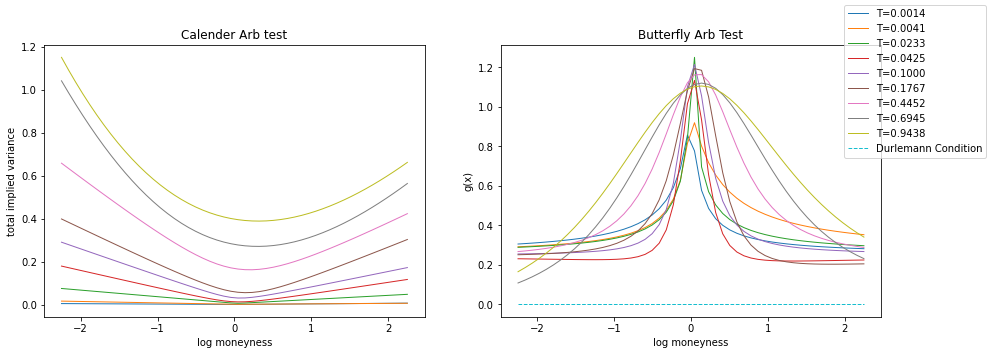

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i,T in enumerate(btc_market['time_to_expiry_yrs'].unique()):
    ax[0].plot(m, T*iv_ssvi[T]**2, linewidth=1, label=f'T={T:.4f}')
    ax[0].set_xlabel('log moneyness')
    ax[0].set_ylabel('total implied variance')
    ax[0].set_title('Calender Arb test')
    
    g_x = [g(x,*param_matrix[T].tolist()) for x in m]
    ax[1].plot(m, g_x, linewidth=1)
    ax[1].set_xlabel('log moneyness')
    ax[1].set_ylabel('g(x)')
    ax[1].set_title('Butterfly Arb Test')
    

ax[1].plot(m, [0]*len(m),'--', linewidth=1, label='Durlemann Condition')
fig.legend()

Calender Arb failed 

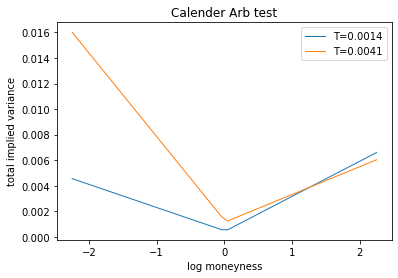

In [50]:
for i,T in enumerate(btc_market['time_to_expiry_yrs'].unique()[:2]):
    plt.plot(m, T*iv_ssvi[T]**2, linewidth=1, label=f'T={T:.4f}')
    plt.xlabel('log moneyness')
    plt.ylabel('total implied variance')
    plt.title('Calender Arb test')
    plt.legend()

### Removing Arbitrage from the Surface

Add Penalty for arbitrages

$$ \min_{a,b,\sigma,\rho,m}\sum_{i=1}^{n}(w_{raw}(x;a,b,\sigma,\rho,m) - w_{mkt})^2 + \lambda_{cal} \cdot max(0,w(x,\tau_{i-1})-w(x,\tau_{i}))^2 + \lambda_{fly} \cdot max(0, -g(x;a,b,\sigma,\rho,m))^2$$

In [21]:
def butterly_arb(a,b,sigma,rho,m, T, market):
    g_x = [g(x,a,b,sigma,rho,m) for x in market.loc[market['time_to_expiry_yrs']==T, 'log_moneyness']]  
    return sum([max(0, -x) for x in g_x])
        
def calender_arb(a,b,sigma,rho,m, T, a_prior, b_prior, sigma_prior, rho_prior, m_prior, T_prior, market):
    if T_prior == 0:
        return 0
    
    w = [raw_svi(x,a,b,sigma,rho,m) for x in market.loc[market['time_to_expiry_yrs']==T, 'log_moneyness']]
    w_prior = [raw_svi(x,a_prior,b_prior,sigma_prior,rho_prior,m_prior) for x in market.loc[market['time_to_expiry_yrs']==T_prior, 'log_moneyness']]
    
    return sum([max(0, prior-now) for now,prior in zip(w,w_prior)])

def residual_penalty(params,T,params_prior,T_prior, market, bpen, cpen):
    barb = butterly_arb(*params, T, market)
    carb = calender_arb(*params, T, *params_prior,T_prior, market)
    w = [raw_svi(x,*params) for x in market.loc[market['time_to_expiry_yrs']==T, 'log_moneyness']]
    iv_actual = market.loc[market['time_to_expiry_yrs']==T, 'mid_iv']
    return iv_actual - (w/T)**0.5 + bpen*barb**2 + cpen*carb**2

In [30]:
blim = 0.001
clim = 0.001

bpen = 10
cpen = 10

maxbarb = 100
maxcarb = 100

no_runs = 0
while maxbarb>blim or maxcarb>clim:
    
    T_prior = 0
    maxbarb = 0
    maxcarb = 0
    no_runs+=1
    
    print(f'run {no_runs}')
    print(f'butterfly penalty factor = {bpen} and calender penalty factor = {cpen}')
    
    results = []
    prev_result = [0,0,0,0,0]
    for T in btc_market['time_to_expiry_yrs'].unique():

        initial_guess = param_matrix[T].tolist()
        if T_prior == 0:
            params_prior = [0,0,0,0,0]
        else:
            params_prior = param_matrix[T_prior].tolist()

        result = least_squares(
            residual_penalty, 
            initial_guess, 
            max_nfev=1000, 
            args=(T, params_prior, T_prior, btc_market, bpen, cpen), 
            verbose=0,
        )

        results.append(result)

        print(f'Ran for T = {T:.4f}: SUCCESS')
        print(result.x)
        b = butterly_arb(*result.x, T, btc_market)
        c = calender_arb(*result.x, T, *prev_result, T_prior, btc_market)
        
        print(f'butterfly penalty = {bpen*b} and calender penalty = {cpen*c}')
        
        maxbarb=max(maxbarb,b)
        maxcarb=max(maxcarb,c)
            
        T_prior = T
        prev_result = result.x
        
    print(f'Maximum butterfly arb = {maxbarb} and calender arb = {maxcarb}')
    print(' ')
    
    if maxbarb > blim:
        bpen*=10
    if maxcarb > clim:
        cpen*=10

print(f'Final maximum butterfly arb = {maxbarb} and calender arb = {maxcarb}')

run 1
butterfly penalty factor = 10 and calender penalty factor = 10
Ran for T = 0.0014: SUCCESS
[4.56992737e-04 2.27901417e-03 5.54923958e-07 2.05963387e-01
 1.52296828e-02]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.0041: SUCCESS
[ 1.17946804e-03  4.35622088e-03  7.54099513e-07 -5.00677526e-01
  1.95233938e-02]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.0233: SUCCESS
[ 0.00508071  0.02485496  0.03870182 -0.22896516  0.03236501]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.0425: SUCCESS
[-0.00644138  0.06798503  0.28203662 -0.19975293  0.00813219]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.1000: SUCCESS
[ 0.0068883   0.09887211 -0.24407126 -0.25954978  0.01324497]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.1767: SUCCESS
[-0.01669649  0.15923678 -0.45363925 -0.08486194  0.11121227]
butterfly penalty = 0 and calender penalty = 0
Ran for T = 0.4452: SUCCESS
[-0.0077709   0.23015839  0.75339825 -0.2112

In [27]:
param_matrix_2 = create_param_matrix(btc_market, results)
param_matrix_2

,0.001370,0.004110,0.023288,0.042466,0.100000,0.176712,0.445205,0.694521,0.943836
a,4.569927e-04,1.179468e-03,0.005081,-0.006441,0.006888,-0.016696,-0.007771,-2.087665,-4.222705
b,2.279014e-03,4.356221e-03,0.024855,0.067985,0.098872,0.159237,0.230158,0.817575,1.322025
σ,5.549240e-07,7.540995e-07,0.038702,0.282037,-0.244071,-0.453639,0.753398,-3.156504,-4.203991
ρ,2.059634e-01,-5.006775e-01,-0.228965,-0.199753,-0.259550,-0.084862,-0.211267,-0.406235,-0.558319
m,1.522968e-02,1.952339e-02,0.032365,0.008132,0.013245,0.111212,0.036430,-1.100660,-2.516265


In [28]:
m, iv_ssvi_2 = generate_surface(btc_market, param_matrix_2)

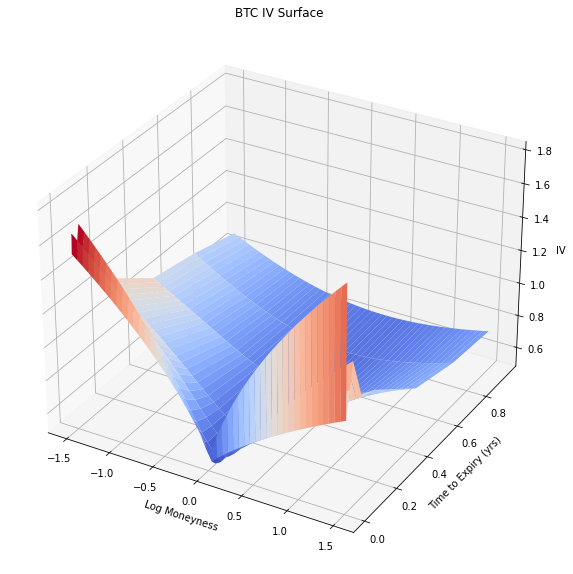

In [29]:
plot_surface(btc_market, m , iv_ssvi_2)

## Reference

1) The Calibrated SSVI Method - Implied Volaitlity Surface Construction by Adam Ohman